GMM + BERT Embedding Model Overview



# Uploading Dataset and Data Cleaning

1. Importing Libraries
2. Downloading NLTK Resources: Download NLTK resources (stopwords, wordnet)
3. Defining Airline List: Create a list of airlines to identify in the tweets.
4. Creating clean_text Function:

  * Convert Emojis to Text
  * Expand Contractions
  * Remove Hashtags but keep word
  * Extract Airline Mentions and then remove them
  * Detect and Remove Hyperlinks
  * Remove Punctuation and Convert to Lowercase
  * Apply Lemmatization

5. Apply Cleaning Function: Apply the clean_text function to the dataset.
6. Display DataFrame: Display the cleaned DataFrame using df.head().



In [1]:
import pandas as pd
file_path = "Tweets.csv"
df = pd.read_csv(file_path)
df

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...
14634,positive,0.3487,@AmericanAir thank you we got on a different f...
14635,negative,1.0000,@AmericanAir leaving over 20 minutes Late Flig...
14636,neutral,1.0000,@AmericanAir Please bring American Airlines to...
14637,negative,1.0000,"@AmericanAir you have my money, you change my ..."


In [4]:
# Download packages
#!pip install contractions
#!pip install emoji

import contractions
import re
import pandas as pd
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Pre-processing steps
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

airline_list = ["VirginAmerica", "united", "SouthwestAir", "JetBlue", "USAirways", "AmericanAir"]

# Function to clean data
def clean_text(text):
    # Convert emojis to text descriptions
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Expand contractions (e.g., "can't" → "cannot")
    text = contractions.fix(text)

    # Remove hashtags but keep words
    text = re.sub(r'#(\w+)', r'\1', text)

    # Extract airline name if mentioned
    airline_pattern = r'@(' + '|'.join(airline_list) + r')\b'
    match = re.search(airline_pattern, text, re.IGNORECASE)
    airline = match.group(1) if match else "Unknown"

    # Remove airline mentions
    text = re.sub(airline_pattern, '', text, flags=re.IGNORECASE).strip()

    # Detect and remove hyperlinks
    link_pattern = r'http\S+'
    has_link = 1 if re.search(link_pattern, text) else 0
    text = re.sub(link_pattern, '', text).strip()

    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()

    # Remove stopwords and apply lemmatization
    #words = text.split()
    #words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    #text = " ".join(words)

    # Apply lemmatization
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words]
    text = " ".join(words)

    return airline, has_link, text

df[['airline', 'has_link', 'clean_text']] = df['text'].apply(lambda x: pd.Series(clean_text(x)))

df.head()

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>


,airline_sentiment,sentiment_confidence,text,airline,has_link,clean_text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.,VirginAmerica,0,what dhepburn said
1,positive,0.3486,@VirginAmerica plus you've added commercials t...,VirginAmerica,0,plus you have added commercial to the experien...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica,0,i did not today must mean i need to take anoth...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...,VirginAmerica,0,it is really aggressive to blast obnoxious ent...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...,VirginAmerica,0,and it is a really big bad thing about it


# Train and test split
The goal is to train the model on one subset (training data) and evaluate its performance on the other (test data) to assess its generalization capability.



* Keeping random_state= 100 ensures that the train-test split is reproducible
* 80-20 Split: 80% of the data is used for training the model and 20% of the data is used for testing the model




In [5]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=100)

# Display the shape of the splits
print(f"Training data size: {X_train.shape[0]}")
print(f"Test data size: {X_test.shape[0]}")


Training data size: 11711
Test data size: 2928


# Gaussian Mixture Model (GMM)
The Gaussian Mixture Model (GMM) is a probabilistic model that assumes the data is generated from a mixture of several Gaussian distributions. Each Gaussian represents a cluster, and GMM estimates the parameters of these distributions to assign data points to the most likely cluster.

In this implementation, we use GMM to perform unsupervised clustering on text data. The text is first converted into high-dimensional embeddings using a pre-trained transformer model, such as SentenceTransformer, which can vary depending on the choice of model (e.g., MiniLM, RoBERTa, etc.). These embeddings capture semantic features from the text, making it possible to group similar text data together. After encoding the text data, dimensionality reduction techniques like PCA (Principal Component Analysis) or UMAP (Uniform Manifold Approximation and Projection) can be applied to reduce the high-dimensional embeddings to a lower-dimensional space, typically 2D, for better visualization.

Once the data is reduced to two dimensions, GMM is used to identify clusters in the training data, and the model predicts the clusters for the test data. The clusters are then mapped to labels (such as sentiment labels) using a majority voting strategy, where the most common label in each cluster from the training data is assigned to the corresponding cluster. The predicted labels are then evaluated using standard classification metrics like accuracy, precision, recall, and F1 score. Lastly, a visualization technique, such as a scatter plot, is used to display the clustering results, showing the distribution of the data points in the reduced 2D space, with color-coding for clusters and labels.

# GMM Implementation (using MiniLM)

1. Importing Libraries:

2. Initialize Sentence Transformer Model:
  * Initialize the SentenceTransformer model (in this case, all-MiniLM-L6-v2) to convert text into embeddings suitable for sentiment analysis.

3. Convert Text to BERT Embeddings:
  * Encode the training (X_train) and test (X_test) data into BERT embeddings using the pre-trained model. This converts raw text data into dense vector representations.

4. Dimensionality Reduction with PCA:
  * Apply Principal Component Analysis (PCA) to reduce the dimensionality of the BERT embeddings to 100 components, making the data easier to work with and more suitable for clustering.

5. Apply Gaussian Mixture Model (GMM):
  * Fit a Gaussian Mixture Model (GMM) on the reduced training data. The GMM is used for clustering the data into 3 components (ideally corresponding to positive, negative, and neutral sentiments).

6. Predict Clusters for Test Data:
  * Predict the sentiment clusters for the test data using the fitted GMM.

7. Map Clusters to Sentiment Labels:
  * Map the predicted clusters to actual sentiment labels (positive, neutral, negative) based on the majority sentiment in each cluster of the training data. The most common label within each cluster is assigned to that cluster.

8. Assign Predicted Sentiment Labels:
  * Assign the predicted sentiment labels (positive, neutral, or negative) to the test data based on the cluster mapping.

9. Model Evaluation:
  * Evaluate the model's performance using:
    * Classification Report: Displays precision, recall, F1-score, and support for each class.
    * Accuracy Score: Measures the overall accuracy of the predictions.

10. Data Visualization:
Visualize the clustering results using a scatter plot, where the reduced dimensions (PCA components) of the test data are plotted, and the clusters are color-coded. This helps visualize how well the GMM has clustered the data.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.90      0.81      1863
     neutral       0.00      0.00      0.00       609
    positive       0.38      0.52      0.44       456

    accuracy                           0.66      2928
   macro avg       0.37      0.47      0.42      2928
weighted avg       0.53      0.66      0.58      2928

Accuracy: 0.6568


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

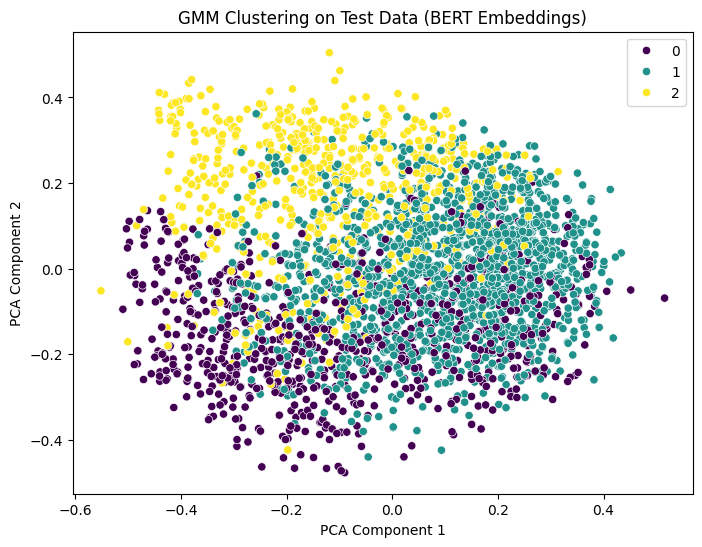

In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert text into BERT embeddings
X_train_bert = model.encode(X_train.tolist(), convert_to_tensor=False)
X_test_bert = model.encode(X_test.tolist(), convert_to_tensor=False)

# Reduce dimensions using PCA (retain 100 components)
pca = PCA(n_components=100, random_state=42)
X_train_reduced = pca.fit_transform(X_train_bert)
X_test_reduced = pca.transform(X_test_bert)

# Apply Gaussian Mixture Model (GMM) on training data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_reduced)

# Predict clusters for test data
y_pred_clusters = gmm.predict(X_test_reduced)

# Map clusters to sentiment labels using majority vote (training data)
cluster_mapping = {}
train_clusters = gmm.predict(X_train_reduced)  # Get cluster assignments for training data

for cluster in range(3):
    true_labels = y_train.iloc[np.where(train_clusters == cluster)]
    if not true_labels.empty:
        cluster_mapping[cluster] = true_labels.mode()[0]  # Assign the most common label in the cluster

# Assign predicted sentiment labels
y_pred_labels = [cluster_mapping.get(cluster, 'negative') for cluster in y_pred_clusters]  # Default to 'negative'

# Evaluation: Accuracy, Precision, Recall, and F1 Score
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=y_pred_clusters, palette='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering on Test Data (BERT Embeddings)")
plt.show()

# GMM Implementation (using RoBERTa)

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      1.00      0.78      1863
     neutral       0.00      0.00      0.00       609
    positive       0.00      0.00      0.00       456

    accuracy                           0.64      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.40      0.64      0.49      2928

Accuracy: 0.6363


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

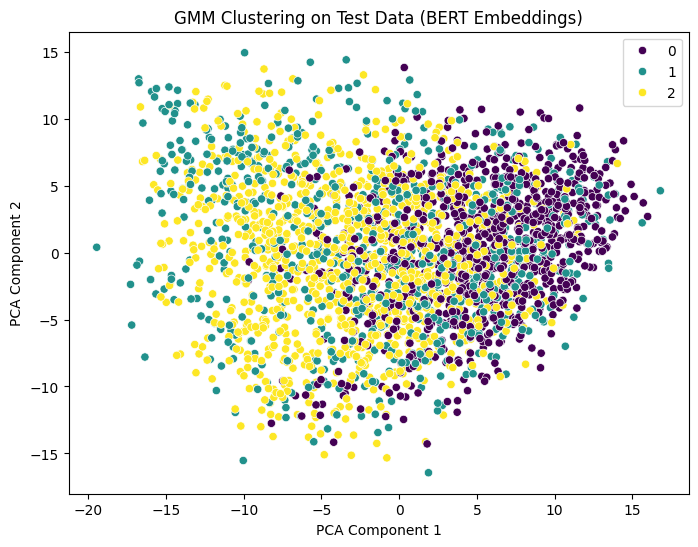

In [7]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

model = SentenceTransformer('stsb-roberta-large')


# Convert text into BERT embeddings
X_train_bert = model.encode(X_train.tolist(), convert_to_tensor=False)
X_test_bert = model.encode(X_test.tolist(), convert_to_tensor=False)

# Reduce dimensions using PCA (retain 100 components)
pca = PCA(n_components=100, random_state=42)
X_train_reduced = pca.fit_transform(X_train_bert)
X_test_reduced = pca.transform(X_test_bert)

# Apply Gaussian Mixture Model (GMM) on training data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_reduced)

# Predict clusters for test data
y_pred_clusters = gmm.predict(X_test_reduced)

# Map clusters to sentiment labels using majority vote (training data)
cluster_mapping = {}
train_clusters = gmm.predict(X_train_reduced)  # Get cluster assignments for training data

for cluster in range(3):
    true_labels = y_train.iloc[np.where(train_clusters == cluster)]
    if not true_labels.empty:
        cluster_mapping[cluster] = true_labels.mode()[0]  # Assign the most common label in the cluster

# Assign predicted sentiment labels
y_pred_labels = [cluster_mapping.get(cluster, 'negative') for cluster in y_pred_clusters]  # Default to 'negative'

# Evaluation: Accuracy, Precision, Recall, and F1 Score
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=y_pred_clusters, palette='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering on Test Data (BERT Embeddings)")
plt.show()

# GMM Implementation (using MiniLM)
PCA components adjusted from 2 to 100

Model still visualizes only 2 dimensions (first 2 components), but GMM is applied in 100-D space, seeing a richer, more accurate representation of the data, ideally improving clustering performance.



Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.91      0.81      1863
     neutral       0.00      0.00      0.00       609
    positive       0.36      0.48      0.41       456

    accuracy                           0.66      2928
   macro avg       0.37      0.47      0.41      2928
weighted avg       0.52      0.66      0.58      2928

Accuracy: 0.6561


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

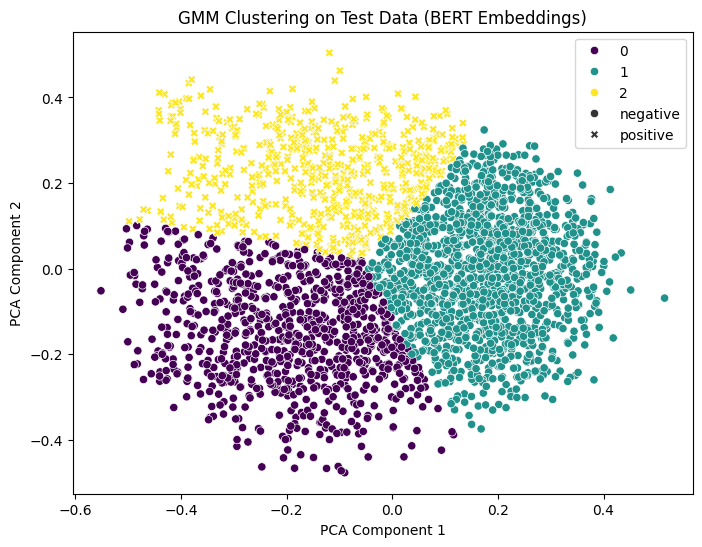

In [8]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model for better embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Or 'all-mpnet-base-v2' for even better accuracy

# Convert text into BERT embeddings
X_train_bert = model.encode(X_train.tolist(), convert_to_tensor=False)
X_test_bert = model.encode(X_test.tolist(), convert_to_tensor=False)

# Reduce dimensions using PCA or UMAP for better spreading of data
# Using PCA with smaller components for better visualization (try n_components=2)
pca = PCA(n_components=2, random_state=42)  # Use 2 components for better visualization
X_train_reduced = pca.fit_transform(X_train_bert)
X_test_reduced = pca.transform(X_test_bert)

# Apply Gaussian Mixture Model (GMM) on training data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_reduced)

# Predict clusters for test data
y_pred_clusters = gmm.predict(X_test_reduced)

# Map clusters to sentiment labels using majority vote (training data)
cluster_mapping = {}
train_clusters = gmm.predict(X_train_reduced)  # Get cluster assignments for training data

for cluster in range(3):
    true_labels = y_train.iloc[np.where(train_clusters == cluster)]  # Get true labels of cluster
    if not true_labels.empty:
        cluster_mapping[cluster] = true_labels.mode()[0]  # Assign most common label in the cluster

# Assign predicted sentiment labels
y_pred_labels = [cluster_mapping.get(cluster, 'negative') for cluster in y_pred_clusters]  # Default to 'negative'

# Evaluation: Accuracy, Precision, Recall, and F1 Score
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=y_pred_clusters, palette='viridis', style=y_pred_labels)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering on Test Data (BERT Embeddings)")
plt.show()


# Data Cleaning version 2

1. Stopwords:
  * First version doesn't remove stopwords while the second version removes stopwords before lemmatization to reduce noise in the text.

2. Handling of Short Words and Numbers:
  * Second version removes short words (words with fewer than 3 characters) and numbers, which is not done in the first version.


In [9]:
import contractions
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

airline_list = ["VirginAmerica", "united", "SouthwestAir", "JetBlue", "USAirways", "AmericanAir"]

def pos_tagger(token):
    # Use WordNet Lemmatizer for all words
    return lemmatizer.lemmatize(token)

def clean_textver2(text):
    # Convert emojis
    text = emoji.demojize(text, delimiters=(" ", " "))  # 😊 → " smiley face "

    # Expand contractions
    text = contractions.fix(text)

    # Remove hashtags but keep words
    text = re.sub(r'#(\w+)', r'\1', text)

    # Extract airline name if mentioned
    airline_pattern = r'@(' + '|'.join(airline_list) + r')\b'
    match = re.search(airline_pattern, text, re.IGNORECASE)
    airline = match.group(1) if match else "Unknown"

    # Remove airline mentions
    text = re.sub(airline_pattern, '', text, flags=re.IGNORECASE).strip()

    # Detect and remove hyperlinks
    link_pattern = r'http\S+'
    has_link = 1 if re.search(link_pattern, text) else 0
    text = re.sub(link_pattern, '', text).strip()

    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove numbers and short words
    text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if len(word) > 2])  # Remove short words

    # Lemmatization with POS tagging
    words = text.split()
    words = [pos_tagger(w) for w in words]
    text = " ".join(words)

    return airline, has_link, text


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1018)>


In [11]:
df2 = pd.read_csv("Tweets.csv")
df2[['airline', 'has_link', 'clean_text']] = df2['text'].apply(lambda x: pd.Series(clean_textver2(x)))

# Check the first few rows of the dataframe
df2.head()


,airline_sentiment,sentiment_confidence,text,airline,has_link,clean_text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.,VirginAmerica,0,what dhepburn said
1,positive,0.3486,@VirginAmerica plus you've added commercials t...,VirginAmerica,0,plus you have added commercial the experience ...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica,0,did not today must mean need take another trip
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...,VirginAmerica,0,really aggressive blast obnoxious entertainmen...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...,VirginAmerica,0,and really big bad thing about


# Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (80-20 split)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2['text'], df2['airline_sentiment'], test_size=0.2, random_state=100)

# Display the shape of the splits
print(f"Training data size: {X_train2.shape[0]}")
print(f"Test data size: {X_test2.shape[0]}")


Training data size: 11711
Test data size: 2928


# GMM Implementation with Preprocessed Text Data Version 2 (MiniLM)



Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.91      0.81      1863
     neutral       0.00      0.00      0.00       609
    positive       0.36      0.48      0.41       456

    accuracy                           0.66      2928
   macro avg       0.37      0.47      0.41      2928
weighted avg       0.52      0.66      0.58      2928

Accuracy: 0.6561


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

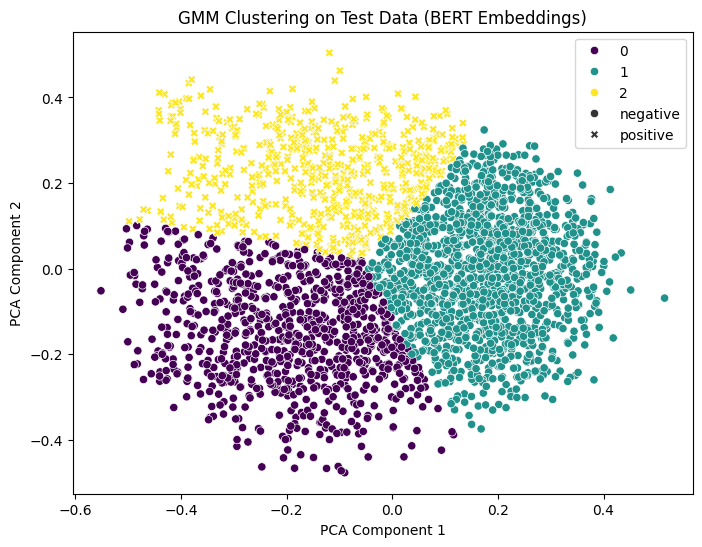

In [13]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model for better embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Or 'all-mpnet-base-v2' for even better accuracy

# Convert text into BERT embeddings
X_train_bert2 = model.encode(X_train2.tolist(), convert_to_tensor=False)
X_test_bert2 = model.encode(X_test2.tolist(), convert_to_tensor=False)

# Reduce dimensions using PCA or UMAP for better spreading of data
# Using PCA with smaller components for better visualization (try n_components=2)
pca = PCA(n_components=2, random_state=42)  # Use 2 components for better visualization
X_train_reduced = pca.fit_transform(X_train_bert2)
X_test_reduced = pca.transform(X_test_bert2)

# Apply Gaussian Mixture Model (GMM) on training data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_reduced)

# Predict clusters for test data
y_pred_clusters = gmm.predict(X_test_reduced)

# Map clusters to sentiment labels using majority vote (training data)
cluster_mapping = {}
train_clusters = gmm.predict(X_train_reduced)  # Get cluster assignments for training data

for cluster in range(3):
    true_labels = y_train.iloc[np.where(train_clusters == cluster)]  # Get true labels of cluster
    if not true_labels.empty:
        cluster_mapping[cluster] = true_labels.mode()[0]  # Assign most common label in the cluster

# Assign predicted sentiment labels
y_pred_labels = [cluster_mapping.get(cluster, 'negative') for cluster in y_pred_clusters]  # Default to 'negative'

# Evaluation: Accuracy, Precision, Recall, and F1 Score
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=y_pred_clusters, palette='viridis', style=y_pred_labels)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering on Test Data (BERT Embeddings)")
plt.show()


# GMM Implementation with Preprocessed Text Data Version 2 (roBERTa)

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.89      0.84      1863
     neutral       0.00      0.00      0.00       609
    positive       0.44      0.80      0.57       456

    accuracy                           0.69      2928
   macro avg       0.41      0.56      0.47      2928
weighted avg       0.57      0.69      0.62      2928

Accuracy: 0.6909


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

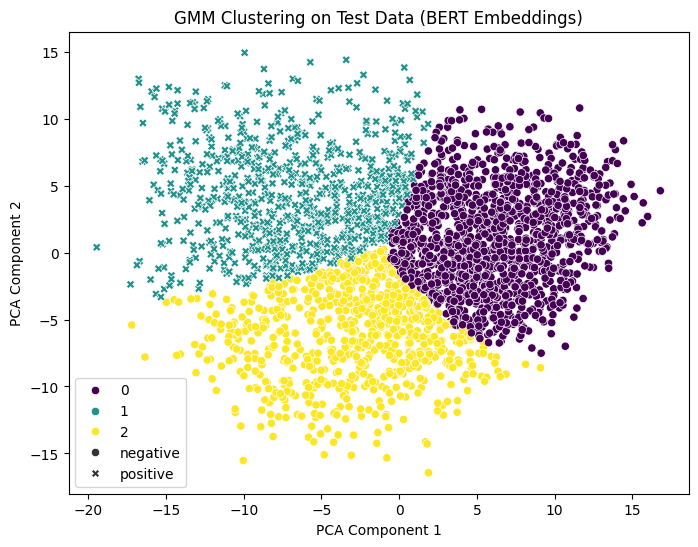

In [14]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model for better embeddings
model = SentenceTransformer('stsb-roberta-large')  # Or 'all-mpnet-base-v2' for even better accuracy

# Convert text into BERT embeddings
X_train_bert2 = model.encode(X_train2.tolist(), convert_to_tensor=False)
X_test_bert2 = model.encode(X_test2.tolist(), convert_to_tensor=False)

# Reduce dimensions using PCA or UMAP for better spreading of data
# Using PCA with smaller components for better visualization (try n_components=2)
pca = PCA(n_components=2, random_state=42)  # Use 2 components for better visualization
X_train_reduced = pca.fit_transform(X_train_bert2)
X_test_reduced = pca.transform(X_test_bert2)

# Apply Gaussian Mixture Model (GMM) on training data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_reduced)

# Predict clusters for test data
y_pred_clusters = gmm.predict(X_test_reduced)

# Map clusters to sentiment labels using majority vote (training data)
cluster_mapping = {}
train_clusters = gmm.predict(X_train_reduced)  # Get cluster assignments for training data

for cluster in range(3):
    true_labels = y_train.iloc[np.where(train_clusters == cluster)]  # Get true labels of cluster
    if not true_labels.empty:
        cluster_mapping[cluster] = true_labels.mode()[0]  # Assign most common label in the cluster

# Assign predicted sentiment labels
y_pred_labels = [cluster_mapping.get(cluster, 'negative') for cluster in y_pred_clusters]  # Default to 'negative'

# Evaluation: Accuracy, Precision, Recall, and F1 Score
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=y_pred_clusters, palette='viridis', style=y_pred_labels)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clustering on Test Data (BERT Embeddings)")
plt.show()


# Analysis

The method with the highest accuracy of 69% is the RoBERTa model applied to Data Cleaning Version 2, where stopwords have been removed. This suggests that removing stopwords from the text data improved the model's ability to capture the relevant features for classification, allowing RoBERTa to perform more effectively. The relatively moderate accuracy could indicate that while the model benefits from data preprocessing, there might still be room for further optimization, such as experimenting with additional preprocessing steps, hyperparameter tuning, or even exploring alternative models to achieve better performance.

# References
